In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

from collections import Counter
from typing import Dict, List, Tuple
from time import perf_counter

from boilerplate import get_accuracy, count_parameters, EarlyStopping

## Data Preprocessing

This has been simplified significantly compared to the IMDB data:
- The entire dataset is just one file (per subset) that we can read in one go, assuming it isn't too large.
- We don't want to "destroy" the text through standardization methods like removing punctuation or lowercasing.
- The `.tokens` versions of Wikitext has already been tokenized, e.g. punctuation has been split off. If you were to use a different dataset, you might need to add aditional steps to achieve this!
- We don't use special start/stop tokens, although these could in principle be added.
- We split the data into sequences of equal length, so no padding is needed.

The result is a simple array dataset of shape `N x T` -- `N` sequences of length `T` each.

In [ ]:
# this uses the wiki text data set.
# can be downloaded here https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/
# I use the word level version
import os

def process_data(path, keep_num_tokens, words=False, raw=True, subsets=("train", "valid", "test")):
    if raw:
        suffix = "raw"
    else:
        suffix = "tokens"

    subset_dict = {}
    for subset in subsets:
        print("Reading {} data...".format(subset))
        with open(os.path.join(path, "wiki.{}.{}".format(subset, suffix)), "r") as data_file:
            data_full = data_file.read()
        if words:
            data_full = data_full.split(" ")
        subset_dict[subset] = data_full

    print("Counting tokens in training set...")
    vocab_counter = Counter(subset_dict["train"])
    vocab_count = vocab_counter.most_common()

    plt.loglog([v[1] for v in vocab_count])
    plt.xlabel("Token index (sorted)")
    plt.ylabel("Number of occurrences")
    plt.show()


    cutoff = keep_num_tokens
    common_tokens = [pair[0] for pair in vocab_count[:cutoff]]
    vocabulary = common_tokens

    ind_to_token = dict(zip(range(len(vocabulary)), vocabulary))
    if raw:
        ind_to_token[cutoff] = "<unk>"

    token_to_ind = {t: i for (i, t) in ind_to_token.items()}
    if not raw:
        unk_ind = token_to_ind["<unk>"]
    else:
        unk_ind = cutoff

    mapped_dict = {}
    for subset in subsets:
        print("Tokenizing {}...".format(subset))
        mapped_dict[subset] = [token_to_ind.get(token, unk_ind) for token in subset_dict[subset]]

    # we do another count after including the mapping to <unk>
    count_unk = Counter(mapped_dict["train"])
    print("Proportion of unknown tokens in training set:", count_unk[unk_ind] / len(mapped_dict["train"]))

    return mapped_dict, ind_to_token, token_to_ind, len(vocabulary)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading train data...
Reading valid data...
Reading test data...
Counting tokens in training set...


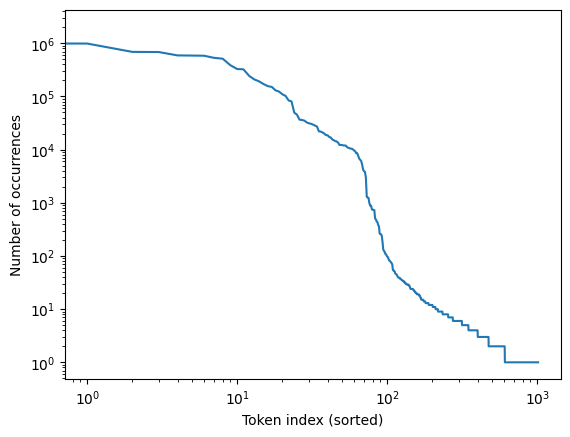

Tokenizing train...
Tokenizing valid...
Tokenizing test...
Proportion of unknown tokens in training set: 5.6782318205913204e-05


In [ ]:
words = False
raw = True
if not words:  # force raw if using characters
    raw = True
subsets = ["train", "valid", "test"]

# you can play around with the vocab size. Obviously this increases computational requirements, especially RAM.
# but a small vocab size means an excessive amount of <unk> tokens, which will also infest our generated texts.
vocab_size = 500
path = "/content/drive/MyDrive/IDL - data/Assignment-7/wikitext-2"
if raw:
    path += "-raw"
mapped_dict, ind_to_token, token_to_ind, num_tokens = process_data(path, vocab_size, words=words, raw=raw, subsets=subsets)

In [ ]:
# I did most of my experiments with a context of 512 tokens.
# of course, shorter sequences reduce computation requirements, especially for Transformers (very memory-hungry)

context_length = 256
slice_dict = {}
for subset in subsets:
    mapped = mapped_dict[subset]
    length_to_use = (len(mapped) // context_length) * context_length
    slice_dict[subset] = np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))

# OPTIONAL
# shifted, to get data with overlap.
# this doesn't really increase amount of data, but shows the words in slightly different contexts
use_shifted = True
if use_shifted:
    for subset in subsets:
        mapped = mapped_dict[subset]
        mapped_shifted = mapped[context_length//2:]
        length_to_use = (len(mapped_shifted) // context_length) * context_length
        slices_shifted =  np.array(mapped[:length_to_use], dtype=np.int64).reshape((-1, context_length))
        slice_dict[subset] = np.concatenate((slice_dict[subset], slices_shifted), axis=0)

In [ ]:
print("Train shape", slice_dict["train"].shape)
print("Valid shape", slice_dict["valid"].shape)
print("Test shape", slice_dict["test"].shape)

Train shape (85302, 256)
Valid shape (8942, 256)
Test shape (10065, 256)


In [ ]:
# we can just create a dataset directly form the numpy arrays!
train_dataset = slice_dict["train"]
valid_dataset = slice_dict["valid"]
test_dataset = slice_dict["test"]

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for thing in train_loader:
    print(thing)
    break

tensor([[ 2,  1,  7,  ...,  8,  1,  4],
        [ 0, 21,  0,  ...,  4,  3, 10],
        [ 3, 12,  9,  ...,  5,  2,  3],
        ...,
        [ 0, 12, 14,  ..., 19,  0, 21],
        [ 5, 17,  2,  ...,  3, 16,  1],
        [ 2,  8,  0,  ..., 13,  3, 10]])


## Transformer Basics

Note: If you decide to rather go with an RNN, you can ignore this section.

As you recall, the original Transformer consists of an _encoder_, which consumes a given sequence at once, and a _decoder_, which attends to the encoded sequence as well as _masked_ attention to its own output sequence. Language models are usually regarded as "decoder-only" Transformers, since they used masked self-attention and produce an output sequence. However, in Pytorch we need to use the `TransformerEncoder` module, since the `Decoder` requires an encoded input sequence, which we don't have. Luckily the `Encoder` supports masking on the inputs.

First, we need a function for a single Transformer layer:

In [ ]:
# mini model to showcase
# NOTE batch_first=True -- not important in this parameter showcase, but very important when you build the model
layer = nn.TransformerEncoderLayer(d_model=4, nhead=2, dim_feedforward=6, batch_first=True)

In [ ]:
enc = nn.TransformerEncoder(layer, num_layers=3)

As we see above, building the full Transformer stack is simple -- just put in the `Layer` module and say how many layers you want. However, there is an issue here -- the layer is simply cloned, which also duplicates the exact same initialized parameter values! This is generally undesirable, though likely not a complete disaster: The parameters are cloned to the same values, but _not_ shared, so they can still learn different weights as we train the model.

In [ ]:
# single layer weights
for param in layer.named_parameters():
    print(param)

('self_attn.in_proj_weight', Parameter containing:
tensor([[-0.1250, -0.4742, -0.5365, -0.3352],
        [-0.2849,  0.5607, -0.0555,  0.3156],
        [ 0.0224, -0.1629, -0.0628, -0.4798],
        [ 0.5169,  0.0546,  0.5396, -0.2116],
        [-0.5031, -0.3906,  0.1766, -0.0909],
        [-0.1751, -0.0022, -0.1976,  0.0067],
        [ 0.5178, -0.0366, -0.5142, -0.1775],
        [ 0.4680,  0.0140,  0.4060,  0.0908],
        [ 0.1002,  0.2331, -0.4765,  0.5769],
        [ 0.4550, -0.1618,  0.3754,  0.5063],
        [-0.2362, -0.0810, -0.0441, -0.4367],
        [-0.5769,  0.0626, -0.0167,  0.2049]], requires_grad=True))
('self_attn.in_proj_bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))
('self_attn.out_proj.weight', Parameter containing:
tensor([[-0.4168,  0.3989,  0.3612,  0.2780],
        [ 0.0630,  0.3347, -0.2335, -0.2822],
        [ 0.2768,  0.4657, -0.3195, -0.4849],
        [ 0.4505, -0.2975,  0.4068,  0.1021]], requires_gr

In [ ]:
# compare the weights in the different encoder layers. each layer has the same weights! this is bad!
for llll in enc.layers:
    print("NEXT LAYER")
    for param in llll.named_parameters():
        print(param)
        np_par = param[1].detach().numpy()
        print()
        print(np.mean(np_par), np.std(np_par))
        print()
    print("\n\n\n")

NEXT LAYER
('self_attn.in_proj_weight', Parameter containing:
tensor([[-0.1250, -0.4742, -0.5365, -0.3352],
        [-0.2849,  0.5607, -0.0555,  0.3156],
        [ 0.0224, -0.1629, -0.0628, -0.4798],
        [ 0.5169,  0.0546,  0.5396, -0.2116],
        [-0.5031, -0.3906,  0.1766, -0.0909],
        [-0.1751, -0.0022, -0.1976,  0.0067],
        [ 0.5178, -0.0366, -0.5142, -0.1775],
        [ 0.4680,  0.0140,  0.4060,  0.0908],
        [ 0.1002,  0.2331, -0.4765,  0.5769],
        [ 0.4550, -0.1618,  0.3754,  0.5063],
        [-0.2362, -0.0810, -0.0441, -0.4367],
        [-0.5769,  0.0626, -0.0167,  0.2049]], requires_grad=True))

-0.013373514 0.33412492

('self_attn.in_proj_bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

0.0 0.0

('self_attn.out_proj.weight', Parameter containing:
tensor([[-0.4168,  0.3989,  0.3612,  0.2780],
        [ 0.0630,  0.3347, -0.2335, -0.2822],
        [ 0.2768,  0.4657, -0.3195, -0.4849],
        [ 0

In [ ]:
# re-initialize the layers
def init_transformer(mod):
    if isinstance(mod, nn.TransformerEncoderLayer):
        torch.nn.init.xavier_uniform_(mod.self_attn.in_proj_weight)
        torch.nn.init.xavier_uniform_(mod.self_attn.out_proj.weight)
        torch.nn.init.xavier_uniform_(mod.linear1.weight)
        torch.nn.init.xavier_uniform_(mod.linear2.weight)
        torch.nn.init.zeros_(mod.linear1.bias)
        torch.nn.init.zeros_(mod.linear2.bias)

enc.apply(init_transformer)

TransformerEncoder(
  (layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
      )
      (linear1): Linear(in_features=4, out_features=6, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=6, out_features=4, bias=True)
      (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [ ]:
# now each layer has new weights!
for llll in enc.layers:
    print("NEXT LAYER")
    for param in llll.named_parameters():
        print(param)
        np_par = param[1].detach().numpy()
        print()
        print(np.mean(np_par), np.std(np_par))
        print()
    print("\n\n\n")

NEXT LAYER
('self_attn.in_proj_weight', Parameter containing:
tensor([[-0.5152,  0.4608, -0.4076, -0.5404],
        [-0.4491, -0.4988, -0.0932, -0.3963],
        [ 0.1658, -0.4900, -0.4940,  0.2932],
        [ 0.4218,  0.2083,  0.5597, -0.2179],
        [ 0.3605, -0.5503,  0.4016, -0.1979],
        [-0.1001,  0.3753,  0.4966,  0.0751],
        [-0.5795, -0.2704,  0.5061, -0.4083],
        [-0.5607,  0.1985,  0.4570,  0.4727],
        [-0.0250, -0.2174,  0.0984, -0.1020],
        [-0.6003, -0.5709, -0.0585, -0.5537],
        [-0.0316,  0.3792,  0.2385, -0.5558],
        [ 0.5766,  0.2685,  0.4382, -0.4326]], requires_grad=True))

-0.05135094 0.39838508

('self_attn.in_proj_bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

0.0 0.0

('self_attn.out_proj.weight', Parameter containing:
tensor([[-0.6451,  0.1930,  0.5963, -0.7436],
        [-0.6518, -0.4197,  0.1215, -0.6265],
        [-0.3664,  0.6816, -0.1792, -0.2894],
        [-0.

One component that Pytorch does not come with is the positional encoding. The below is [adapted from Stackoverflow](https://stackoverflow.com/questions/77444485/using-positional-encoding-in-pytorch).

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000, max_wavelen=10000.0):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(max_wavelen) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.permute(1, 0, 2))  # change to batch-first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

In [ ]:
# I changed the max_wavelen from 10000, because with that, we just get a lot of "nothing" in the slowest wavelengths (highest dimensions).
# try removing the max_wavelen argument to see what I mean.
posenc = PositionalEncoding(64, max_wavelen=6*context_length)

xx = torch.randn(1, 500, 64)

posenc(xx)

tensor([[[ 1.2987,  0.2228,  0.5639,  ...,  2.4258, -0.7694,  1.7860],
         [ 2.7806,  2.1546,  2.2751,  ...,  0.3864, -0.1992, -1.0619],
         [-0.2485,  1.3720,  0.9177,  ...,  0.0000,  2.2249,  1.7410],
         ...,
         [-0.1513, -0.0139, -1.0860,  ..., -0.1870,  0.7300, -0.0000],
         [ 0.0000,  0.0000, -0.0999,  ...,  3.0714,  1.0725,  0.0000],
         [-1.0080, -1.4094,  1.6844,  ..., -0.0000,  0.6703,  0.1357]]])

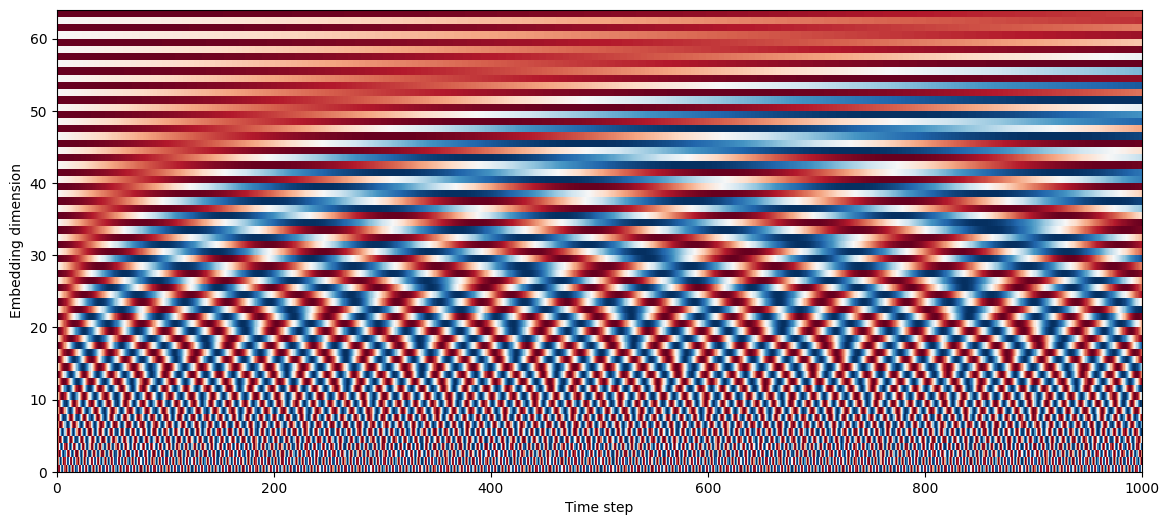

In [ ]:
plt.figure(figsize=(14, 6))
plt.pcolormesh(posenc.pe[0].T, vmin=-1, vmax=1, cmap="RdBu_r")
plt.xlabel("Time step")
plt.ylabel("Embedding dimension")
plt.show()

## Language Model

Here we include a "scaffolding" to build a language model, with several parts left unfinished. You can use it if you want, or create your own from scratch. In general, we need a model that takes an input sequence and, at each time step, predicts (i.e. outputs a probability distribution) the next token, given the previous ones. Since during training, we have the full input sequence given, the output should also just be a sequence. Luckily, applying a `Linear` layer to a sequence works just fine -- it is "duplicated" over the sequence length and applied to each time step separately.

Probably the most challenging thing here is to implement the `generate` function. It should go as follows:
- Start with a prompt; this is basically what gets the generation going, as we can't predict the "next" token if there is no input.
- The prompt is consumed by the model to get a probability over the next token
- _Sample_ from the distiribution, i.e. you take a random token depending on the probabilities output by the model.
  - You could also try argmax instead, i.e. always using the token with the highest probablity. However, this is likely to devolve into the network repeating itself over and over.
- The sampled token then goes back into the network to get a prediction over the next token, etc.
- Repeat until you have the desired number of tokens. Concatenate all tokens into a sequence, map back from numbers to words we can read, and return the result.

This function will differ significantly between Transformers and RNNs.

Some advanced options are:
- Temperature: A number, usually < 1, that you divide the logits by before the softmax. This results in probabilities becoming more extreme (closer to 0/1), which makes it less likely to pick "bad" words. You could also use temperatures larger than 1 to make logits closer to 0, leading to more uniform probabilities, and thus more random sampling. But this is usually not very helpful.
- Top-K sampling: Keep only the K largest probabilities for some value of K, and sample from those. This completely eliminates the possibility of drawing unlikely words. As such, it is more effective than temperature sampling, but also harder to implement. You can also combine it with temperature sampling.
- To prevent excessive `<unk>` generations, the token can be excluded from the outputs.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, d_model, token_to_ind, ind_to_token):
        super().__init__()
        vocab_size = len(token_to_ind)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_wavelen=6*context_length)  # only needed for Transformers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dim_feedforward=d_model*4, batch_first=True)
        self.body = nn.TransformerEncoder(encoder_layer,num_layers=3)  # could be a nn.TransformerEncoder, or maybe an nn.GRU etc.
        self.output_layer = nn.Linear(d_model, vocab_size)

        self.body.apply(init_transformer)  # only needed for Transformers

        # these will be needed for generation
        self.token_to_ind = token_to_ind
        self.ind_to_token = ind_to_token
        self.unk_ind = token_to_ind["<unk>"]

    def forward(self, inputs):
        # if using a Transformer, you should supply a "causal" mask to prevent it from looking into the future
        #mask = nn.Transformer.generate_square_subsequent_mask(inputs.shape[1], device=inputs.device)
        embedded = self.embedding(inputs)
        pos_enc = self.positional_encoding(embedded)
        state = self.body(pos_enc)#, mask=mask, is_causal=True)
        return self.output_layer(state)

    def generate(self, num_sequences=1, num_tokens=context_length, prompt=None,
                 temperature=1., top_k=None, remove_unk=False):
        # NOTE this function assumes a Transformer model.
        # for RNNs, things become a lot more finicky as you have to carry around the state and feed tokens
        # as well as the previous state one-by-one.
        # generating with a Transformer is generally much simpler.
        with torch.no_grad():
            generated = []

            # convert text prompt to indices, repeating it n times over batch axis for n sequences to be generated
            if prompt is not None:
                split_prompt = prompt.split() if words else prompt
                token_prompt = [token_to_ind.get(token, self.unk_ind) for token in split_prompt]
                # create num_sequences copies of the prompt as a tensor
                previous_token = torch.tile(torch.tensor(token_prompt, dtype=torch.int64, device=device)[None], [num_sequences, 1])
                generated.append(previous_token.detach().cpu().numpy())
            else:
                # if not prompted, I use the newline character.
                # this generally preceeds new sections etc. (in WikiText) so it's a reasonable starting point.
                previous_token = token_to_ind["\n"] * torch.ones((num_sequences, 1), dtype=torch.int64, device=device)

            for time_step in range(num_tokens):
                # this should consume what we have so far (e.g. previous_token) and give us a b x v matrix
                # containing the distributions (one per batch element) over the next token.
                # v is vocabulary size.
                # as always, you likely do not want to have a Softmax in your model, so these would be the logits
                next_logits = self.forward(previous_token)[:, -1, :]

                if remove_unk:
                    next_logits = torch.cat((next_logits[:, :self.unk_ind],
                                             next_logits[:, self.unk_ind+1:]), dim=-1)

                # here is the most important part.
                # you will want to generate a b x 1 "matrix" of new tokens, one per sequence in the batch.
                # you should do this by randomly sampling from the b x v matrix you acquired above (next_logits).
                # check out torch.distributions.Categorical and its sample() method.
                if temperature == 0:
                    # temperature of 0 corresponds to argmax sampling.
                    # you can leave this unimplemented at first, and use temperatures > 0.
                    random_draw = torch.argmax(next_logits, dim=-1, keepdim=True)
                else:
                    next_logits = next_logits / temperature  # optional: apply temperature here

                    if top_k is not None:
                        # this is a bit more tricky. check out torch.topk.
                        # I would advise that you leave this out and focus on the standard case (in the else-condition)
                        values, indices = torch.topk(next_logits, top_k, dim=-1) # Referred: https://docs.pytorch.org/docs/stable/generated/torch.topk.html
                        distribution = torch.distributions.Categorical(logits=values) # Referred: https://docs.pytorch.org/docs/stable/distributions.html
                        samples = distribution.sample().unsqueeze(1)
                        random_draw = torch.gather(indices, 1, samples)
                    else:
                        distribution = torch.distributions.Categorical(logits=next_logits)
                        random_draw = distribution.sample().unsqueeze(1)

                # annoying: if we removed the unknown token from the model output, the indices no longer
                # correspond to the original words. so we have add 1 to restore the proper indices.
                if remove_unk:
                    random_draw[random_draw >= self.unk_ind] += 1

                # after drawing a new token, we append it to the previous ones so we can put it back into our model for the next round.
                # previous_token will be b x t (with t growing each step), as such random_draw should be b x 1
                previous_token = torch.cat((previous_token, random_draw), axis=1)[:, -context_length:]

                generated.append(random_draw.detach().cpu().numpy())

        # at the very end, we can just concatenate everything and turn it into strings again
        generated = np.concatenate(generated, axis=1)
        # global variable "words", oh weh
        join_string = " " if words else ""
        generated = [join_string.join([ind_to_token[ind] for ind in sequence]) for sequence in generated]
        return generated

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)
model = LanguageModel(d_model = 128, token_to_ind = token_to_ind, ind_to_token = ind_to_token)
model = model.to(device)

print(model)

print(count_parameters(model))

cuda
LanguageModel(
  (embedding): Embedding(501, 128)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (body): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=501, bias=True)
)
723573


In [ ]:
# test prompted and unprompted generation
# obviously, the model is untrained, but good idea to check whether this runs without crashing...
model.generate(num_sequences=2, num_tokens=20, prompt="Mount Everest is")

["Mount Everest is्きæøテº周'ァ李iพųаδま光बिი",
 'Mount Everest is陈ư″لリ礮″½Aაmιūy½ḏ隊åəо']

In [ ]:
model.generate(num_sequences=8, num_tokens=20)

['ĀСơχ♭あɪ1оåÚîлñядDйω礮',
 'сÞकйñ″⅔ूOS]h¡ήœの†ùвし',
 'くнs.กć″КMv張Ł狐雪のåリ\ufeffწま',
 '×სżàდ侗澤ีც攻ėţთ&οفºˌיs',
 'ʊηū์AπÎđñảすっ\\ấ動礮ό₹å้',
 'იŚოช隊ჳ<unk>яήṭớっ–हì×キძṃl',
 '6ზ’iPAčأ周XدæァảǎNÞ7旭)',
 'µちჱ王ยÖ้ρ9ュbŌ陈²ხί/¥ر王']

In [ ]:
# note: Transformer models sometimes require smaller learning rates. E.g. you could try 0.0002 if it seems to be stuck in the beginning
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

## Training and Evaluation

These proceed much the same as before. It's a little different as our dataset contains no labels. Rather, the targets are just the inputs shifted back by one time step.

Consider the following:

In [ ]:
sequence = ["what", "is", "the", "next", "word"]

print(sequence[:-1])
print(sequence[1:])

['what', 'is', 'the', 'next']
['is', 'the', 'next', 'word']


Maybe that can help you somehow... Be very careful: In training we have *batches* of sequences, and you need to make sure that you are indexing the correct axis to shift the time steps.

As for the loss function -- Cross-entropy! Yes, even a giant GPT model would be using the same loss function and learning algorithm we've been using every week. Luckily, it handles sequences just well -- it will average over the time axis just like over the batch axis.

As such, we can mostly reuse our trusty training code from before, replicated below (with a few steps missing).

In [ ]:
def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                device: str,
                verbose: bool = True) -> Dict[str, np.ndarray]:
    n_training_examples = len(training_loader.dataset)
    batches_per_epoch = n_training_examples // training_loader.batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=3*scheduler.patience, verbose=verbose)

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, sequence_batch in enumerate(training_loader):
            sequence_batch = sequence_batch.to(device)
            input_batch = sequence_batch[:, :-1]
            label_batch = sequence_batch[:, 1:]
            batch_loss, batch_accuracy = train_step(input_batch, label_batch, model, loss_fn, optimizer, device)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = evaluate(model, validation_loader, loss_fn, device)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}


def train_step(input_batch: torch.tensor,
               label_batch: torch.tensor,
               model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)
    output_batch = model(input_batch)
    batch_loss = loss_fn(output_batch.transpose(2, 1), label_batch)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = get_accuracy(label_batch, output_batch)
    return batch_loss, batch_accuracy


def evaluate(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for sequence_batch in dataloader:
            sequence_batch = sequence_batch.to(device)
            input_batch = sequence_batch[:, :-1]
            label_batch = sequence_batch[:, 1:]
            predictions = model(input_batch)
            val_loss += loss_fn(predictions.transpose(2, 1), label_batch)
            correct += (predictions.argmax(axis=-1) == label_batch).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / (size * context_length)
    return val_loss, val_accuracy

In [ ]:
metrics = train_model(model, loss_fn, optimizer, scheduler, train_loader, valid_loader,
                      n_epochs=15, device=device)

Running 15 epochs at 666 steps per epoch.
Starting epoch 1... New best value found; no longer disappointed
Time taken: 95.6496612890005 seconds
	Train/val loss: 1.7962611336876322 / 0.07044763118028641
	Train/val accuracy: 0.4957365755403593 / 0.9781508445739746
	LR is now 0.001
Starting epoch 2... New best value found; no longer disappointed
Time taken: 95.58583622799961 seconds
	Train/val loss: 0.12037085210932447 / 0.013952412642538548
	Train/val accuracy: 0.9662114439067898 / 0.9926016330718994
	LR is now 0.001
Starting epoch 3... New best value found; no longer disappointed
Time taken: 95.14075837699966 seconds
	Train/val loss: 0.041956301697448746 / 0.011299067176878452
	Train/val accuracy: 0.9886233800345355 / 0.9930943846702576
	LR is now 0.001
Starting epoch 4... New best value found; no longer disappointed
Time taken: 95.0796031179998 seconds
	Train/val loss: 0.0260451181788926 / 0.010207985527813435
	Train/val accuracy: 0.9929990712049845 / 0.993272602558136
	LR is now 0.001

## Generation

For reference, on a small dataset like Wikitext-2, you may expect a validation cross-entropy of around 4.0-5.0 or so. Overfitting is very likely due to the small size of the dataset.

Below are some proposals to test the generation code, trying different temperatures and values for top-k. You can of course add anything you want, e.g. starting with certain prompts.

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = model.generate(num_sequences=6, num_tokens=20, temperature= temperature, prompt = "IDL is ")
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

IDL is IIIIIIIIIIIIIIIIIIII


NEW SEQUENCE

IDL is IIIIIIIIIIIIIIIIIIII


NEW SEQUENCE

IDL is . ..................


NEW SEQUENCE

IDL is ....................


NEW SEQUENCE

IDL is PPPPPPPPPPPPPPPPPPPP


NEW SEQUENCE

IDL is . ..................


TEMPERATURE 0.9

NEW SEQUENCE

IDL is ssssssssssssssssssss


NEW SEQUENCE

IDL is ! ! ! AAAAAAAAAAAAAA


NEW SEQUENCE

IDL is ....................


NEW SEQUENCE

IDL is ssssssssssssssssssss


NEW SEQUENCE

IDL is . . IIIIIIIIIIIIIIII


NEW SEQUENCE

IDL is . ..................


TEMPERATURE 0.8

NEW SEQUENCE

IDL is SSSSSSSSSSSSSSSSSSSS


NEW SEQUENCE

IDL is AAAAAAAAAAAAAAAAAAAA


NEW SEQUENCE

IDL is , , , IIIIIIIIIIIIII


NEW SEQUENCE

IDL is PPPPPPPPPPPPPPPPPPPP


NEW SEQUENCE

IDL is . ..................


NEW SEQUENCE

IDL is s . IIIIIIIIIIIIIIII


TEMPERATURE 0.6

NEW SEQUENCE

IDL is . ..................


NEW SEQUENCE

IDL is IIIIIIIIIIIIIIIIIIII


NEW SEQUENCE

IDL is AAAAAAAAAAAAAAAAAAAA


NEW SEQU

In [ ]:
for temperature in [1., 0.9, 0.8, 0.6, 0.3, 0.1, 0.]:
    print("TEMPERATURE", temperature)
    print()
    gens = model.generate(num_sequences=6, num_tokens=400, temperature=temperature, prompt = "IDL is " ,remove_unk=True)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

TEMPERATURE 1.0

NEW SEQUENCE

IDL is . ................................................................................................................................................................................................................................................................................................. i............................... I...s .......... n...B..H........... r.....ad ......... t.. L..............


NEW SEQUENCE

IDL is , IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIILLLIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


NEW SEQUENCE

IDL is ssssssssssssssssssssssssssssssssssssssssssssQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQنالراااالانفالפооооооороввийルо

In [ ]:
for k in [1, 2, 5, 10, 25, 50, 100, 250]:
    print("K", k)
    print()
    gens = model.generate(num_sequences=6, num_tokens=400, temperature=0.9, top_k=k, prompt="IDL is",remove_unk=True)
    for thing in gens:
        print("NEW SEQUENCE")
        print()
        print(thing)
        print("\n")

K 1

NEW SEQUENCE

IDL issssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss ass ssssss ass ssssss ass ssssss ass ssssss ass sssss ass sssss ass sasss ass sasss ass sasss as sssss as ssssas sssss as sssss as sssss as sssss as s


NEW SEQUENCE

IDL issssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss ass ssssss ass ssssss ass ssssss ass ssssss ass sssss ass sssss ass sasss ass sasss ass sasss as sssss as ssssas sssss as sssss as sssss as sssss as s


NEW SEQUENCE

IDL issssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss